# I. Condorcet's Jury Theorem (1785)

Assume voter probability be correct as $p>.5$.

1. Plot the probability a jury of $n$ voters (odd) is correct as a function of $p$ for different $n$ using Monte-Carlo simulations (sampling and averaging)

2. Prove that as number of jury members grows, $n\rightarrow\infty$, the  jury majority becomes correct  $\Pr(\text{correct}) \rightarrow 1$ (**hint**: use the law of large numbers)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [15]:
monte_carlo = 5000
p_list = np.linspace(0.5, 1, 50)
jury_size_list = np.arange(1, 100, 20)

result_jury = []
for jury_size in tqdm(jury_size_list):
    result_p = []
    for p in p_list: #voting engine: 1 line :)
        result_p.append(np.mean(np.random.binomial(jury_size, p, monte_carlo) > (jury_size // 2)))
    result_jury.append(result_p)

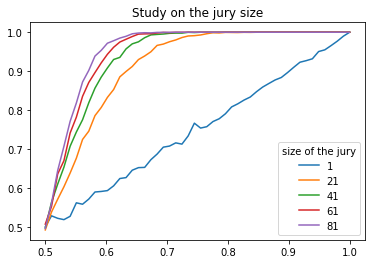

In [16]:
for result in result_jury:
    plt.plot(p_list, result)
plt.legend(jury_size_list, title="size of the jury")
plt.title("Study on the jury size")
plt.show()

In [17]:
monte_carlo = 5000
# p_list = np.linspace(0.5, 1, 5)
p_list = [0.5001, 0.51, 0.55, 0.6, 0.8,]
jury_size_list = np.arange(1, 1000, 20)

result_p = []
for p in tqdm(p_list):
    result_jury = []
    for jury_size in jury_size_list:
        result_jury.append(np.mean(np.random.binomial(jury_size, p, monte_carlo) > (jury_size // 2)))
    result_p.append(result_jury)

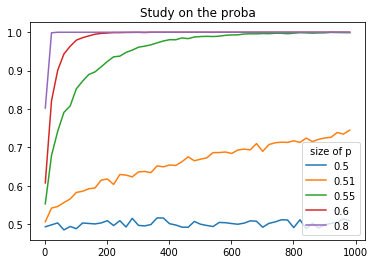

In [18]:
for result in result_p:
    plt.plot(jury_size_list, result)
plt.legend(np.round(p_list,2), title="size of p")
plt.title("Study on the proba")
plt.show()

If the probability for each person to choose correctly is p>50%. Then the law of large numbers states the majority will judge correctly


# II. Boosting Trees from Scratch
* Use the scikit-learn's DecisionTreeRegressor with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* **Optional**: add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.metrics import mean_squared_error
from sklearn.utils.validation import check_X_y, check_is_fitted


class L2boost(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_trees=10, learning_rate=0.1, early_stop=False):
        self._trees = []
        self.f0 = 0
        self.mse = []
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.early_stop = early_stop
  
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        to_loop = True
        tree_id = 0
        if self.early_stop is True:
            last_mse_val = np.inf
            self.X_, self.X_val_, self.y_, self.y_val_ = train_test_split(X, y, test_size=0.20)
        else:
            self.X_ = X
            self.y_ = y
        self.f0 = self.y_.mean()
        y_hat = np.ones(self.y_.shape[0]) * self.f0
        while to_loop is True:
            tree_id += 1
            residue = self.y_ - y_hat
            new_tree = DecisionTreeRegressor(max_depth=1, random_state=42).fit(self.X_, residue)
            self._trees.append(new_tree)
            y_hat += self.learning_rate * new_tree.predict(self.X_)
            self.mse.append(mean_squared_error(self.y_, y_hat))
            if self.early_stop is True:
                mini_bost = L2boost(tree_id, self.learning_rate).fit(self.X_, self.y_)
                new_mse_val = mean_squared_error(self.y_val_, mini_bost.predict(self.X_val_))
                if last_mse_val < new_mse_val:
                    self.mse.pop()
                    to_loop = False
                    self.n_trees = tree_id - 1
                last_mse_val = new_mse_val
            else:
                if tree_id >= self.n_trees:
                    to_loop = False               
        return self
    
    
    def predict(self, X):
#         check_is_fitted(self) # not sure why it's not working
        y_hat = np.ones(X.shape[0]) * self.f0
        for tree in self._trees:
            y_hat +=  self.learning_rate * tree.predict(X)
#         return y_hat
        self.y_ = y_hat
        return self.y_
    
    def score(self, X, y):
        return mean_squared_error(y, self.predict(X))


In [20]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

check BaseEstimator {'early_stop': False, 'learning_rate': 0.1, 'n_trees': 1000}


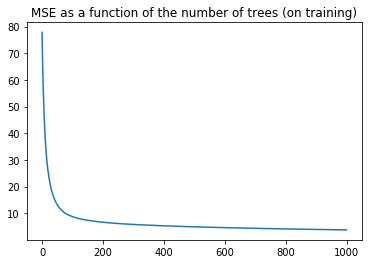

In [21]:
reg = L2boost(1000, 0.1).fit(X_train, y_train)
print("check BaseEstimator", reg.get_params())

plt.plot(reg.mse)
plt.title("MSE as a function of the number of trees (on training)")
plt.show()

#### Search best parameters

score 19.248686125572988, for learing-rate 0.01
score 13.446275471635301, for learing-rate 0.05
score 13.573581178318195, for learing-rate 0.1
score 13.271311549707708, for learing-rate 0.2
score 13.643727670101041, for learing-rate 0.5


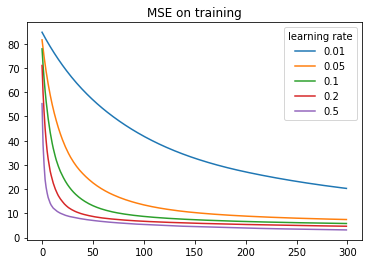

In [22]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5]
for l_rate in learning_rates:
    dtree_boost = L2boost(n_trees=300, learning_rate=l_rate)
    dtree_boost.fit(X_train, y_train)
    print(f'score {dtree_boost.score(X_test, y_test)}, for learing-rate {l_rate}')
    plt.plot(dtree_boost.mse)
plt.legend(learning_rates, title="learning rate")
plt.title("MSE on training")
plt.show()

Plotting is interesting but can lead to errors because it's the MSE on training. The score displayed is useful. To evaluate the perfect model we need to compare the result on the test set. Check below:

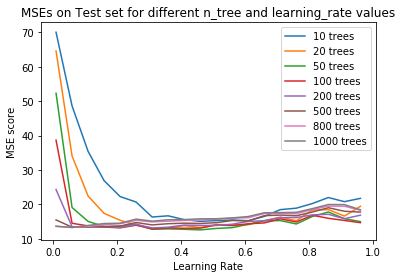

In [23]:
learning_rate_options = np.arange(0.01, 1, 0.05)
n_trees_options = np.array([10, 20, 50, 100, 200, 500, 800, 1000])
best_model = None
best_l_rate = 0
best_n_trees = 0
best_mse = np.inf

ax = plt.subplot(111)
for n_trees in tqdm(n_trees_options):
    mses_for_ntrees = []
    for l_rate in learning_rate_options:
        booster = L2boost(n_trees=n_trees, learning_rate=l_rate).fit(X_train, y_train)
        mse = booster.score(X_test, y_test)
        mses_for_ntrees.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_model = booster
            best_l_rate = l_rate
            best_n_trees = n_trees
    plt.plot(learning_rate_options, mses_for_ntrees, label='{n} trees'.format(n=n_trees))

plt.title('MSEs on Test set for different n_tree and learning_rate values')
plt.xlabel('Learning Rate')
plt.ylabel("MSE score")
plt.legend(loc='best')
plt.show()

In [24]:
print("Best hyperparameters fitted on Validation Set: [n_trees={n_trees} ; learning_rate={l_rate}] achieved mse={mse}".format(n_trees=best_n_trees, l_rate=best_l_rate,mse=best_mse))

Best hyperparameters fitted on Validation Set: [n_trees=50 ; learning_rate=0.46] achieved mse=12.591490420377681


We got an intersting result as for the training set we need to increase as much as we can the number of tree but it just overfit the model. 

Let's try to use sklearn tool to double check.

In [29]:
from sklearn.model_selection import GridSearchCV

my_boost = L2boost()
n_trees_list = np.linspace(10, 600, 5, dtype=int)
lr_list = np.linspace(0.001, 1, 10)

parameters = {'learning_rate': lr_list, 'n_trees': n_trees_list}
gsv = GridSearchCV(my_boost, parameters, return_train_score=True)
gsv.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=L2boost(early_stop=False, learning_rate=0.1, n_trees=10),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                         'n_trees': array([ 10, 157, 305, 452, 600])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [30]:
print(gsv.best_estimator_)
print(gsv.best_score_)
print(gsv.best_params_)

L2boost(early_stop=False, learning_rate=0.001, n_trees=10)
84.83317374902241
{'learning_rate': 0.001, 'n_trees': 10}


it didn't really work so I tried to investigate it

In [31]:
gsv.cv_results_

{'mean_fit_time': array([0.00704519, 0.09954866, 0.18948134, 0.28641335, 0.37269028,
        0.00653307, 0.0980262 , 0.19250631, 0.28471843, 0.38962634,
        0.00680542, 0.10057203, 0.20929726, 0.29308621, 0.3837467 ,
        0.0067877 , 0.09847768, 0.18918514, 0.28170141, 0.37243152,
        0.00634058, 0.09784881, 0.18919571, 0.28126454, 0.37418596,
        0.00636673, 0.09863679, 0.19082077, 0.29416235, 0.39173508,
        0.00690158, 0.10262807, 0.19792581, 0.28062193, 0.41873646,
        0.00637698, 0.09756136, 0.19550268, 0.31462487, 0.38922445,
        0.00650295, 0.10028362, 0.1966757 , 0.28307128, 0.38064885,
        0.00659529, 0.09717957, 0.19463976, 0.28931069, 0.39437707]),
 'std_fit_time': array([5.16788768e-04, 7.78999384e-04, 1.11896714e-04, 4.41999519e-03,
        6.41775145e-04, 1.39722826e-04, 2.41056813e-04, 1.10286605e-03,
        3.65629348e-04, 1.35422868e-02, 4.98795714e-04, 1.97228359e-03,
        1.20059520e-02, 1.66015195e-02, 1.20549863e-02, 4.00811123e-0

We are obtaining a different number of of tree and different number of LR. I tried to narrow it down but I think I have a bug somewhere : it always take the first run as the best run so below I implement a function to search for the best parameter

In [34]:
def search_best_hyperparameter(func, p1_min, p1_max, p2_min, p2_max, nbLoop):
    best_mse = np.inf
    best_p1 = 0
    best_p2 = 0
    hp1 = np.linspace(p1_min, p1_max, nbLoop, dtype=int)
    hp2 = np.linspace(p2_min, p2_max, nbLoop)
    print(hp1, hp2)
    for tp1 in hp1:
        for tp2 in hp2:       
            func_tmp = func(tp1, tp2)
            func_tmp.fit(X_train, y_train)
            y_pred = func_tmp.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            if mse < best_mse:
                best_mse = mse
                best_p1 = tp1
                best_p2 = tp2
    print("best_mse:",best_mse)
    return best_p1, best_p2


def adjut_param(best_p1, best_p2):
    p1_min = int(best_p1 - (best_p1*50/100))
    p1_max = int(best_p1 + (best_p1*50/100))
    p2_min = best_p2 - (best_p2*50/100)
    p2_max = best_p2 + (best_p2*50/100)
    return p1_min, p1_max, p2_min, p1_max


p1_min, p1_max, p2_min, p2_max, nbLoop = (10, 300, 0.001, 0.5, 10)
for _ in range(5):
    best_p1, best_p2 = search_best_hyperparameter(L2boost, p1_min, p1_max, p2_min, p2_max, nbLoop)
    print(best_p1, best_p2,"\n")
    p1_min, p1_max, p2_min, p1_max = adjut_param(best_p1, best_p2)



[ 10  42  74 106 138 171 203 235 267 300] [0.001      0.05644444 0.11188889 0.16733333 0.22277778 0.27822222
 0.33366667 0.38911111 0.44455556 0.5       ]
best_mse: 12.448334084685111
74 0.33366666666666667 

[ 37  45  53  61  69  78  86  94 102 111] [0.16683333 0.20385185 0.24087037 0.27788889 0.31490741 0.35192593
 0.38894444 0.42596296 0.46298148 0.5       ]
best_mse: 12.430829281358086
69 0.3889444444444444 

[ 34  41  49  57  64  72  80  87  95 103] [0.19447222 0.22841975 0.26236728 0.29631481 0.33026235 0.36420988
 0.39815741 0.43210494 0.46605247 0.5       ]
best_mse: 12.264727100946134
34 0.33026234567901236 

[17 20 24 28 32 35 39 43 47 51] [0.16513117 0.20233882 0.23954647 0.27675412 0.31396176 0.35116941
 0.38837706 0.42558471 0.46279235 0.5       ]
best_mse: 12.13834480284951
28 0.31396176268861453 

[14 17 20 23 26 29 32 35 38 42] [0.15698088 0.19509412 0.23320735 0.27132059 0.30943382 0.34754706
 0.38566029 0.42377353 0.46188676 0.5       ]
best_mse: 12.344761899944958
29

We have identify the best nb_tree:29, best lr: 0.30, best_mse: 12.34

#### comparison with DecisionTreeRegressor

In [35]:
depth_param = [5, 10, 15, 20, 25, 30, 40, 50, 100, 200]

best_mse = np.inf
best_depth = None

for dp in depth_param:
    regressor = DecisionTreeRegressor(max_depth=dp).fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_depth = dp
        best_mse = mse
print(f'Params: Depth: {best_depth}, best_mse: {best_mse}')
DecisionTreeRegressor(max_depth=best_depth)

Params: Depth: 5, best_mse: 25.454649049235552


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

DecisionTreeRegressor (mse \~ 11) is better than our Boosting Trees (mse \~ 17)

well, this time
DecisionTreeRegressor (mse \~ 25) is worth than our Boosting Trees (mse \~ 12)

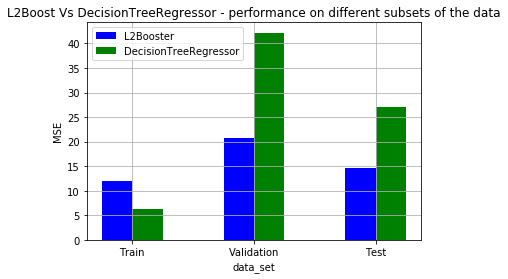

In [38]:
best_model = L2boost(58, 0.10).fit(X_train, y_train)
best_tree = DecisionTreeRegressor(max_depth=best_depth).fit(X_train, y_train)
data_sets = {"Train": (X_train, y_train), "Validation":(X_val, y_val), "Test": (X_test, y_test)}
l2booster_scores = [] #best_model
decisiontree_scores=[] #best_tree

for dataset in data_sets.keys():
    l2booster_scores.append(mean_squared_error(best_model.predict(data_sets[dataset][0]), data_sets[dataset][1]))
    decisiontree_scores.append(mean_squared_error(best_tree.predict(data_sets[dataset][0]), data_sets[dataset][1]))

offset = np.arange(3)

fig, ax = plt.subplots()
plt.title("L2Boost Vs DecisionTreeRegressor - performance on different subsets of the data")
plt.bar(offset + 0.00, l2booster_scores, color = 'b', width = 0.25, label='L2Booster')
plt.bar(offset + 0.25, decisiontree_scores, color = 'g', width = 0.25, label='DecisionTreeRegressor')
plt.ylabel("MSE")
plt.xlabel("data_set")
ax.set_xticks([p  + 0.125 for p in offset])
ax.set_xticklabels(data_sets.keys())
plt.legend()
plt.grid()
plt.show()

We can add an early stop when the error of training and validation dataset are stopped to be corolated. if error on valisation dataset increase: we are overfitting

#### Optional: add an early-stopping

check BaseEstimator {'early_stop': True, 'learning_rate': 0.01, 'n_trees': 293}


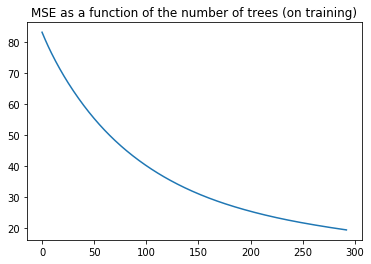

Number of tree in the object is different than the one given in parameter: {'early_stop': True, 'learning_rate': 0.01, 'n_trees': 293}


In [39]:
reg = L2boost(1, 0.01, early_stop=True).fit(X_train, y_train)
print("check BaseEstimator", reg.get_params())

plt.plot(reg.mse)
plt.title("MSE as a function of the number of trees (on training)")
plt.show()
print("Number of tree in the object is different than the one given in parameter:", reg.get_params())

We can see the algo stops with a number of tree different than the one given in parameters (we also make sure the algo doesn't stop when it reaches the given number of tree but not reach the over fitting: it continues till reaching the overfitting)

# III. AdaBoost From Scratch
# We did not cover this material during the lecture. Thus this part is optional. Bonus (20 points)


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?


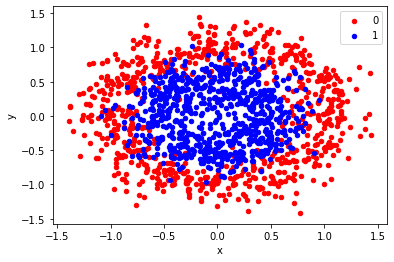

In [40]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [45]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y[y==0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [42]:
class AdaBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, weak_classifier, depth, alpha=0.5):
        self.learner_model = weak_classifier
        self.depth = depth
        self.learner_list = []
        self.weights = []
        self.alpha = alpha
    
    def fit(self, X, y):
        n = X.shape[0]
        weights_cur = np.ones(n) / n
        for _ in range(self.depth):
            X_sample = X[np.random.choice(np.arange(n), size=n, p=weights_cur)]
            new_learner = self.learner_model().fit(X_sample, y)
            self.learner_list.append(new_learner)
            y_pred = new_learner.predict(X)
            error = weights_cur[y_pred!=y].sum()
            self.weights.append(self.alpha * np.log((1 - error) / error))
            weights = weights_cur * np.exp(-self.weights[-1] * y * y_pred)
            weights_cur = weights / np.sum(weights)
        return self
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(self.depth):
            y_pred += self.weights[i] * self.learner_list[i].predict(X)
        return np.sign(y_pred) # can be done differently ?

accuracy for 10 trees/stumps is: 0.699
accuracy for 50 trees/stumps is: 0.835
accuracy for 100 trees/stumps is: 0.845
accuracy for 250 trees/stumps is: 0.859
accuracy for 500 trees/stumps is: 0.864
Best accuracy  = 0.864, achived with a depth of 500 a depth of stumps


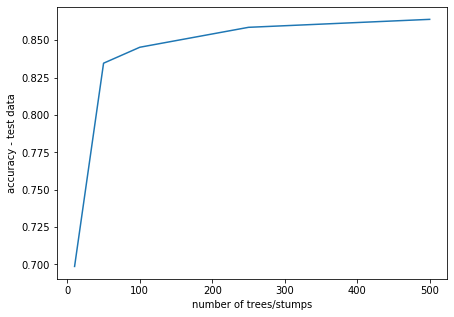

In [48]:
trees = [10, 50, 100, 250, 500]
alpha_list = np.arange(0.2,0.9,0.1)
depth = 250
plt.figure(figsize=(7, 5))

max_accuracy = 0
best_depth = 0

accuracy_for_depth = []
for depth in trees:
# for alpha in alpha_list:
    clf = AdaBoost(LinearSVC, depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = np.mean(y_pred==y_test)
    print(f'accuracy for {depth} trees/stumps is: {accuracy:.3f}')
    accuracy_for_depth.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_depth = depth

# plt.plot(alpha_list, accuracy_for_depth)
plt.plot(trees, accuracy_for_depth)
plt.xlabel("number of trees/stumps")
plt.ylabel("accuracy - test data")
print(f'Best accuracy  = {max_accuracy:.3f}, achived with a depth of {best_depth} a depth of stumps')

In [49]:
plt.style.use("ggplot")


def plot_LR(model, X, y, beauty_mode=False):
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    N = len(model.learner_list)
    estimator_alpha = 1 / N
    for classifier in model.learner_list:
        probs = classifier.predict(grid).reshape(xx1.shape)
        plt.contour(xx1, xx2, probs, [0], linewidths=1, colors='black')
    y_pred = model.predict(X)
    y_pred[y_pred == -1] = 0
    if beauty_mode is True:
        y_pred = y
    plt.scatter(X[:, 0], X[:, 1], c=y_pred)
    plt.title('Decision boundary for n = ' + str(len(model.learner_list)))

We are ploting the data beautifully

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/s

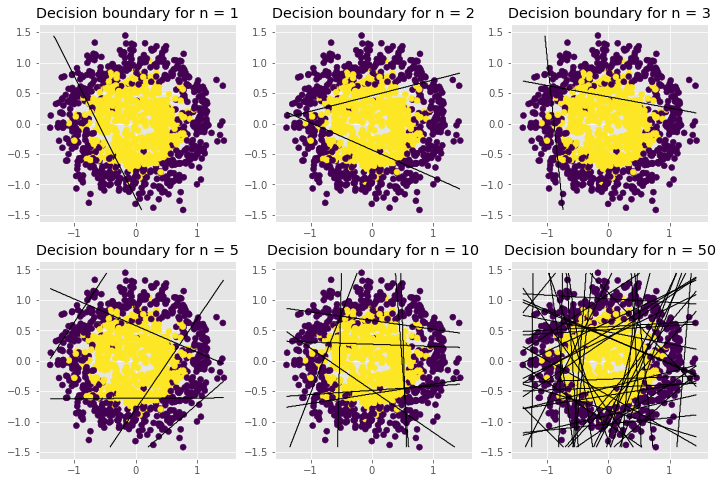

In [50]:
fig = plt.figure(figsize=(12,8))
depth_list = [1, 2, 3, 5, 10, 50]
for i, depth in enumerate(depth_list):
    plt.subplot(2, 3, i + 1)
    model = AdaBoost(LinearSVC, depth).fit(X_train, y_train)
    plot_LR(model, X_train, y_train, beauty_mode=True)

Plotting with real prediction

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]


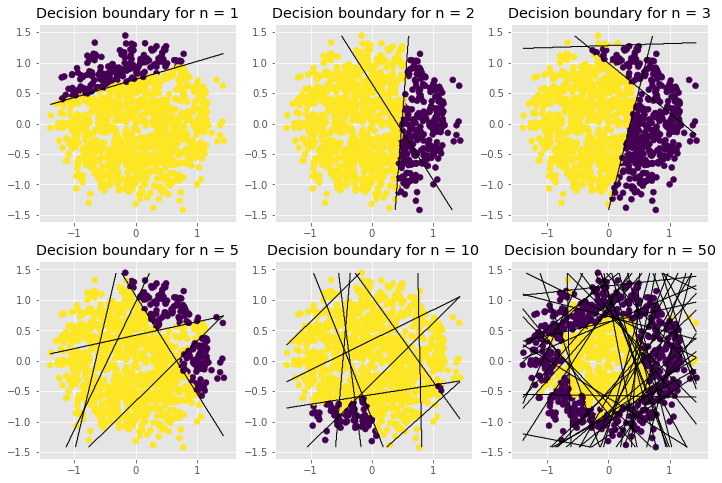

In [51]:
fig = plt.figure(figsize=(12,8))
depth_list = [1, 2, 3, 5, 10, 50]
for i, depth in enumerate(depth_list):
    plt.subplot(2, 3, i + 1)
    model = AdaBoost(LinearSVC, depth).fit(X_train, y_train)
    plot_LR(model, X_train, y_train)


# 